[Hands-On Reinforcement Learning Course: Part 2 - Tabular Q Learning](https://towardsdatascience.com/hands-on-reinforcement-learning-course-part-2-1b0828a1046b)

by [Pau Labarta Bajo](https://pau-labarta-bajo.medium.com/?source=post_page-----269b50e39d08--------------------------------), Dec 7, 2021.  [[github repo for this lesson]](https://github.com/Paulescu/hands-on-rl)

Summarized and Revised by Ivan H.P. Lin

All the code for this lesson is in [this Github repo](https://github.com/Paulescu/hands-on-rl). Git clone it to follow along with today’s problem.

<img src="https://miro.medium.com/max/1050/1*Aef4_9CUysYfv18dulK5uw.jpeg" width="50%">

# 0. Contents

1. The taxi driving problem 🚕
2. Environment, actions, states, rewards
3. Random agent baseline 🤖🍷
4. Q-learning agent 🤖🧠
5. Hyper-parameter tuning 🎛️
6. Recap ✨
7. Homework 📚
8. What’s next? ❤️

#1. 1. The taxi driving problem 🚕
We will teach an agent to drive a taxi using Reinforcement Learning.

Driving a taxi in the real world is a very complex task to start with. Because of this, we will work in a simplified environment that captures the 3 essential things a good taxi driver does, which are:

* pick up passengers and drop them at their desired destination.
* drive safely, meaning no crashes.
* drive them in the shortest time possible.
We will use an environment from **[OpenAI Gym](https://gym.openai.com/)**, called the **[Taxi-v3](https://gym.openai.com/envs/Taxi-v3/)** environment.

<figure><center>
<img src="https://miro.medium.com/max/1050/1*toX5ZWcYxXtsaXE6hQJ1ag.png" width="70%">
<figcaption>Taxi environment (Image by the author)</figcaption>
</figure></center>


There are four designated locations in the grid world indicated by **R(ed)**, **G(reen)**, **Y(ellow)**, and **B(lue)**.

When the episode starts, the taxi starts off at a random square and the passenger is at a random location **(R, G, Y or B)**.

The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. While doing so, our taxi driver needs to drive carefully to avoid hitting any wall, marked as **$|$**. Once the passenger is dropped off, the episode ends.

[![Good taxi driver](https://www.gocoder.one/static/taxi-states-0aad1b011cf3fe07b571712f2123335c.png)](https://youtu.be/eqod3gNoVgU "q agent in the Taxi-v3 environment")



# 2. **Environment**, **Actions**, **States**, **Rewards**
👉🏽 [notebooks/00_environment.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/01_taxi/notebooks/00_environment.ipynb)

## **Actions**
What are the **actions** the agent can choose from at each step?

0. drive down
1. drive up
2. drive right
3. drive left
4. pick up a passenger
5. drop off a passenger

<img src="https://miro.medium.com/max/1050/1*Pzbq6efaMcgpDtLNa80TTw.png" width="60%">

## **States**

And the states?

* 25 possible taxi positions, because the world is a 5x5 grid.
* 5 possible locations of the passenger, which are R, G, Y, B, plus the case when the passenger is in the taxi.
* 4 destination locations

Which gives us 25 x 5 x 4 = 500 states

<img src="https://miro.medium.com/max/1050/1*OJtU-V4bz8PmY4s5G6NDIw.png" width="60%">

## **Rewards**

What about rewards?

* -1 default per-step reward.
  - Why -1, and not simply 0? Because we want to encourage the agent to spend the shortest time, by penalizing each extra step. This is what you expect from a taxi driver, don’t you?
* +20 reward for delivering the passenger to the correct destination.
* -10 reward for executing a pickup or dropoff at the wrong location.

You can read the rewards and the environment transitions (*state*, *action* ) → *next_state* from ```env.P```

<img src="https://miro.medium.com/max/1050/1*jYyrEwM0CfFsw7qmBhnv8g.png" width="50%">

By the way, you can render the environment under each state to double-check this ```env.P``` vectors make sense:

* From ```state=123```
<figure><center>
<img src="https://miro.medium.com/max/1050/1*emheFKcptnVD2KrM7DrQ1g.png" width="60%">
<figcaption>$state=123$</figcaption>
</center></figure>

* The agent moves south action=0 to get to state=223
<figure><center>
<img src="https://miro.medium.com/max/1050/1*t9urLESKVNKcwBKqWxmmlA.png" width="60%">
<figcaption>$state=223$</figcaption>
</center></figure>

And the reward is $-1$, as neither the episode ended, nor the driver incorrectly picked or dropped.




## **00_environment.ipynb**

### **00 Environment**
👉Before you solve a Reinforcement Learning problem you need to define what are
- the actions
- the states of the world
- the rewards

👉We are using the ```Taxi-v3``` environment from [OpenAI's gym](https://gym.openai.com/envs/Taxi-v3/)

👉Taxi-v3 is an easy environment because the action space is small, and the state space is large but finite.

👉Environments with a finite number of actions and states are called tabular

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


### Load the environment 🌎

In [2]:
import gym
env = gym.make("Taxi-v3").env

### **Action space**, **State space**

In [10]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


### **Rewards**

In [11]:
# env.P is double dictionary.
# - The 1st key represents the state, from 0 to 499
# - The 2nd key represens the action taken by the agent,
#   from 0 to 5

# example
state = 123
action = 0  # move south

# env.P[state][action][0] is a list with 4 elements
# (probability, next_state, reward, done)
# 
#  - probability
#    It is always 1 in this environment, which means
#    there are no external/random factors that determine the
#    next_state
#    apart from the agent's action a.
#
#  - next_state: 223 in this case
# 
#  - reward: -1 in this case
#
#  - done: boolean (True/False) indicates wheter the
#    episode has ended (i.e. the driver has dropped the
#    passenger at the correct destination)
print('env.P[state][action][0]: ', env.P[state][action][0])

env.P[state][action][0]:  (1.0, 223, -1, False)


In [13]:
# Need to call reset() at least once before render() will work
env.reset()

env.s = 123
env.render(mode='human')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [14]:
env.s = 223
env.render(mode='human')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



# 3. Random agent baseline 🤖🍷
👉🏽 [notebooks/01_random_agent_baseline.ipynb](https://github.com/Paulescu/hands-on-rl/blob/main/01_taxi/notebooks/01_random_agent_baseline.ipynb)

Before you start implementing any complex algorithm, you should always build a baseline model.

This advice applies not only to Reinforcement Learning problems but Machine Learning problems in general.

It is very tempting to jump straight into the complex/fancy algorithms, but unless you are really experienced, you will fail terribly.

Let’s use a random agent 🤖🍷 as a baseline model.

<img src="https://miro.medium.com/max/1050/1*6I9oN8TQ6-cETliGzCo-yg.png" width="60%">

We can see how this agent performs for a given initial ```state=198```

<img src="https://miro.medium.com/max/1050/1*BhfZjfQ-q4Gnzcl501RUNg.png" width="60%">

[![Random agent in action](https://vitez.me/images/q-learning/taxi.gif)](https://www.youtube.com/watch?v=GExnnTaBELk&feature=emb_rel_end "Random agent in action")

```
<img src="https://drive.google.com/file/d/1tHapRLJtEf0u2ZaoV_2Rzyctz533cCwF/view?usp=sharing">
```

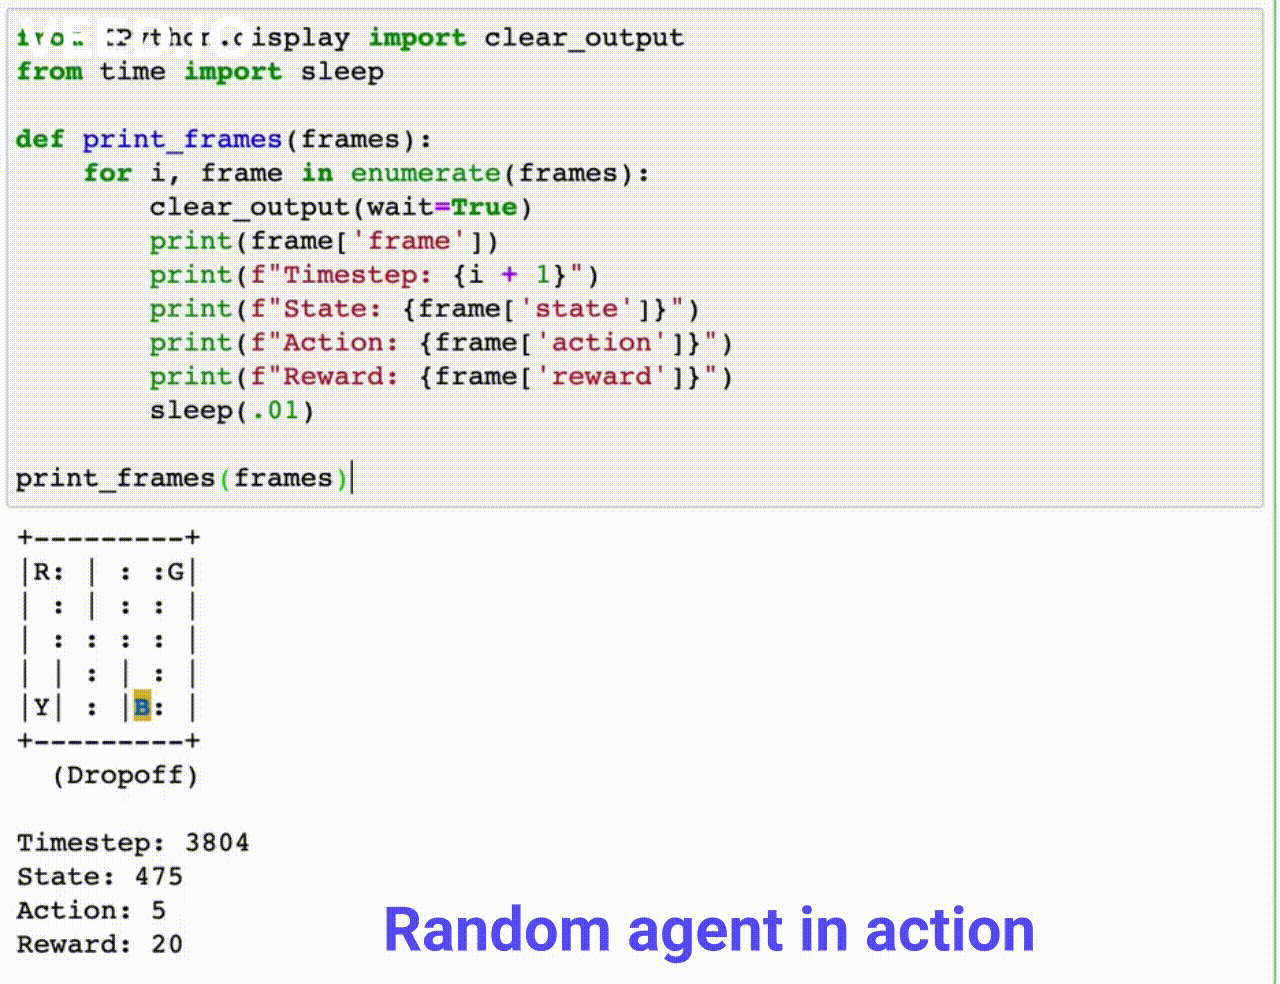

To get a more representative measure of performance, we can repeat the same evaluation loop ```n=100``` times starting each time at a random state.

<img src="https://miro.medium.com/max/1050/1*rGG0oYxuUioE-bVIgc2jhg.png" width="50%">

If you plot ```timesteps_per_episode``` and ```penalties_per_episode``` you can observe that none of them decreases as the agent completes more episodes. In other words, the agent is NOT LEARNING anything.

<img src="https://miro.medium.com/max/1050/1*aPZL0OuLh-1XX6RNgwVL0Q.png" width="50%">


If you want summary statistics of performance you can take averages:
<img src="https://miro.medium.com/max/1050/1*G_3Efv821ncbYJUSuNKJAg.png" width="60%">


Let’s implement our first “intelligent” agent using Q-learning, one of the earliest and most used RL algorithms that exist.

## 01 Random agent baseline

👉Before you try to solve a Reinforcement Learning problem you should get a grasp of its difficulty.

👉 To do so, you need to design a dummy agent that can peform the task without much brains, and evaluate its performance.

👉A simple way to do so is by using a Random Agent, that chooses its next action randomly, without paying attention at the current state of the environment.

👉Needless to say, do not grab a taxi driven by a Random Driver.

In [15]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### Environment 🌎

In [16]:
import gym
env = gym.make("Taxi-v3").env

### **Random agent 🤖🍷**

In [17]:
class RandomAgent:
    """
    This taxi driver selects actions randomly.
    You better not get into this taxi!
    """
    def __init__(self, env):
        self.env = env

    def get_action(self, state) -> int:
        """
        We have `state` as an input to keep
        a consistent API for all our agents, but it
        is not used.
        
        i.e. The agent does not consider the state of
        the environment when deciding what to do next.
        This is why we call it "random".
        """
        return self.env.action_space.sample()

agent = RandomAgent(env)

### evaluate this driver starting from a fixed ```state = 123```

In [20]:
# set initial state of the environment
env.reset()
state = 123
env.s = state

epochs = 0
penalties = 0  # wrong pick up or dropp off
reward = 0

# store frames to latter plot them
frames = []

done = False

while not done:
    
    action = agent.get_action(state)
    
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 3219
Penalties incurred: 1044


In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1} of {len(frames)}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.01)
        
print_frames(frames)

Streaming output truncated to the last 5000 lines.
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 2835 of 3219
State: 159
Action: 5
Reward: -10
+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Timestep: 2836 of 3219
State: 59
Action: 1
Reward: -1
+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Timestep: 2837 of 3219
State: 59
Action: 3
Reward: -1
+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Timestep: 2838 of 3219
State: 59
Action: 4
Reward: -10
+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Timestep: 2839 of 3219
State: 59
Action: 3
Reward: -1
+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Timestep: 2840 of 3219
State: 59
Action: 3
Reward: -1
+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Timestep: 2841 of

### histograms to quantify performance

In [ ]:
from tqdm import tqdm

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []

for i in tqdm(range(0, n_episodes)):
    
    # reset environment to a random state
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        action = agent.get_action(state)       
        next_state, reward, done, info = env.step(action) 
               
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
    
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)